

# <span style="color:#336699">VHI Reference values (1991-2020)</span>
<hr style="border:2px solid #0077b9;">
<div style="text-align: left;">
    <a href="https://nbviewer.org/github/swisstopo/topo-satromo/blob/dev-20241209/codegallery/jupyter/Python/stac/stac-introduction.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>
   
<br/>

<b>Abstract.</b> This Jupyter Notebook derives the 15th percentile and minimal VHI values on a monthly and daily basis and deals with missing values.


<br/>


In [15]:
import ee
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from oauth2client.service_account import ServiceAccountCredentials
from statsmodels.tsa.seasonal import STL

In [16]:
# GEE credentials
config = r'D:\Users\joan-sturm-w1\Documents\GitHub\topo-satromo\secrets\geetest-credentials-int.secret'

Initialize Google Earth Engine (GEE)

In [17]:
def initialize_gee_and_drive():
    """
    Initializes and authenticates Google Earth Engine (GEE) and Google Drive APIs using service account credentials.
    
    This function:
    1. Sets up authentication scopes for Google Drive
    2. Reads service account key file from the config path
    3. Authenticates with Google Drive using the service account credentials
    4. Initializes Google Earth Engine with the same credentials
    5. Performs a test query to verify GEE initialization was successful
    
    Requirements:
        - PyDrive (for Google Drive authentication)
        - Earth Engine Python API (ee)
        - oauth2client (for ServiceAccountCredentials)
        - Valid service account key file path in config variable
    
    Returns:
        None. Prints confirmation message if initialization was successful or failure message otherwise.
    
    Raises:
        FileNotFoundError: If the service account key file cannot be found
        JSONDecodeError: If the service account key file is not valid JSON
        EEException: If Earth Engine initialization fails
    """
    # Set scopes for Google Drive
    scopes = ["https://www.googleapis.com/auth/drive"]

    # Initialize GEE and authenticate using the service account key file

    # Read the service account key file
    with open(config, "r") as f:
        data = json.load(f)

    # Authenticate with Google using the service account key file
    gauth = GoogleAuth()
    gauth.service_account_file = config
    gauth.service_account_email = data["client_email"]
    gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(
        gauth.service_account_file, scopes=scopes
    )

    # Initialize Google Earth Engine
    credentials = ee.ServiceAccountCredentials(
        gauth.service_account_email, gauth.service_account_file
    )
    ee.Initialize(credentials)

    # Test if GEE initialization is successful
    image = ee.Image("NASA/NASADEM_HGT/001")
    title = image.get("title").getInfo()

    if title == "NASADEM: NASA NASADEM Digital Elevation 30m":
        print("GEE initialization successful")
    else:
        print("GEE initialization FAILED")

# Authenticate with GEE and GDRIVE
initialize_gee_and_drive()

GEE initialization successful


<hr style="border:1px solid #0077b9;">

### Defining collections, time and other variables:

In [51]:
# Load the warn regions feature and VHI image collections
regions = ee.FeatureCollection('projects/satromo-prod/assets/res/warnregionen_vhi_2056')
imgCollection = ee.ImageCollection('projects/satromo-prod/assets/col/VHI_HIST_SWISS')

# Set the parameters
landCover = 'VEGETATION'  # Possibilities 'VEGETATION', 'FOREST'
# valid_pixel_threshold = 20  # Percentage of vegetated pixels required
# moy = 12  # month of the year

# Set the time period
startDate = '1991-01-01'
endDate = '2020-12-31'
# monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# monthName = monthNames[moy - 1]  # indexing starts at 0

### VHI Collection
Filter for time frame, region, etc.

In [174]:
# Filter the regions feature collection to isolate target region
region_nr = 42 #[31-69]  
region_feature = regions.filter(ee.Filter.eq('REGION_NR', region_nr)).first()

# Get the region geometry
region_geometry = region_feature.geometry()

# Load the VHI collection and filter by land cover type
vhiCollection = imgCollection \
    .filter(ee.Filter.stringContains('system:index', landCover)) \
    .filterDate(startDate, endDate) \
    .filterBounds(region_geometry)
vhiCollection = vhiCollection.select('vhi')

region_name = region_feature.get('Name').getInfo()
print(f"Analyzing region: {region_nr} - {region_name}")
print(f"Time period: {startDate} to {endDate}")

Analyzing region: 42 - östliches Mittelland
Time period: 1991-01-01 to 2020-12-31


Extracting VHI stats (mean, min, 15th percentile, and valid pixel count):

In [175]:
# Mask invalid values (outside 0-100 range)
def mask_invalid_values(image):
    # Create a mask where VHI values are between 0 and 100
    valid_mask = image.gte(0).And(image.lte(100))
    # Apply the mask to the image
    return image.updateMask(valid_mask)

# Apply masking to the collection
masked_vhi_collection = vhiCollection.map(mask_invalid_values)

# Function to calculate multiple statistics for each image
def calculate_stats(image):
    # Get the region stats with multiple reducers
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.count(), None, True)
            .combine(ee.Reducer.min(), None, True)
            .combine(ee.Reducer.percentile([15]), None, True),
        geometry=region_geometry,
        scale=250,  # Adjust based on your data's resolution
        maxPixels=1e9
    )
    
    # Get image date
    date = ee.Date(image.get('system:time_start'))
    
    # Return a feature with the stats
    return ee.Feature(None, {
        'date': date.format('YYYY-MM-dd'),
        'mean': stats.get('vhi_mean'),
        'min': stats.get('vhi_min'),
        'p15': stats.get('vhi_p15'),  # 15th percentile
        'count': stats.get('vhi_count'),
        'timestamp': image.get('system:time_start')
    })

# Apply the stats calculation to each image
stats_collection = ee.FeatureCollection(masked_vhi_collection.map(calculate_stats))

# Sort by timestamp
stats_collection = stats_collection.sort('timestamp')

# Convert to a list for processing
stats_list = stats_collection.toList(stats_collection.size())

# Get the stats as a list of dictionaries
stats_data = stats_list.getInfo()

# Extract the data for plotting
dates = [stat['properties']['date'] for stat in stats_data]
means = [stat['properties']['mean'] for stat in stats_data]
mins = [stat['properties']['min'] for stat in stats_data]
p15s = [stat['properties']['p15'] for stat in stats_data]
counts = [stat['properties']['count'] for stat in stats_data]

print(f"Total number of images processed: {len(dates)}")

Total number of images processed: 360


### Time series processing
Fill the gaps in the time series with STL

In [176]:
# Create a pandas dataframe
df = pd.DataFrame({
    'date': [datetime.strptime(d, '%Y-%m-%d') for d in dates],
    'mean': means,
    'min': mins,
    'p15': p15s,
    'pixel_count': counts
})

# Set date as the index
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Check for missing data
print(f"Number of missing values: {df['mean'].isna().sum()}")

Number of missing values: 19


In [177]:
# Create a function to perform weighted STL decomposition with gap filling
def fill_gaps_with_stl(time_series, period=12):
    """
    Fill gaps in time series using STL decomposition 
    
    Parameters:
    -----------
    time_series : pandas Series
        The time series with missing values
    pixel_counts : pandas Series
        Number of valid pixels for each observation
    period : int
        The seasonal period (12 for monthly data)
        
    Returns:
    --------
    pandas Series with filled gaps and confidence scores
    """
    # Create a copy of the series to work with
    ts_filled = time_series.copy()
    
    # Step 1: Initial linear interpolation to create a continuous series
    ts_interpolated = ts_filled.interpolate(method='linear')
    
    # Step 2: Apply STL decomposition with robustness for outlier resistance
    stl = STL(ts_interpolated, period=period, robust=True)
    result = stl.fit()
    
    # Get the trend and seasonal components
    trend = result.trend
    seasonal = result.seasonal
    
    # Step 3: Use the trend and seasonal components to reconstruct missing values
    missing_indices = ts_filled.index[ts_filled.isna()]
    for idx in missing_indices:
        loc = ts_filled.index.get_loc(idx)
        # Reconstructed value = trend + seasonal component
        reconstructed_value = trend[loc] + seasonal[loc]
        # Ensure values stay within VHI range (0-100)
        reconstructed_value = min(max(reconstructed_value, 0), 100)
        ts_filled[idx] = reconstructed_value
    
    return ts_filled

# Apply the gap filling function to our monthly VHI time series
ts_filled_mean = fill_gaps_with_stl(df['mean'])
ts_filled_min = fill_gaps_with_stl(df['min'])
ts_filled_p15 = fill_gaps_with_stl(df['p15'])

D:\Users\joan-sturm-w1\AppData\Local\Temp\1\ipykernel_7840\2297586787.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reconstructed_value = trend[loc] + seasonal[loc]


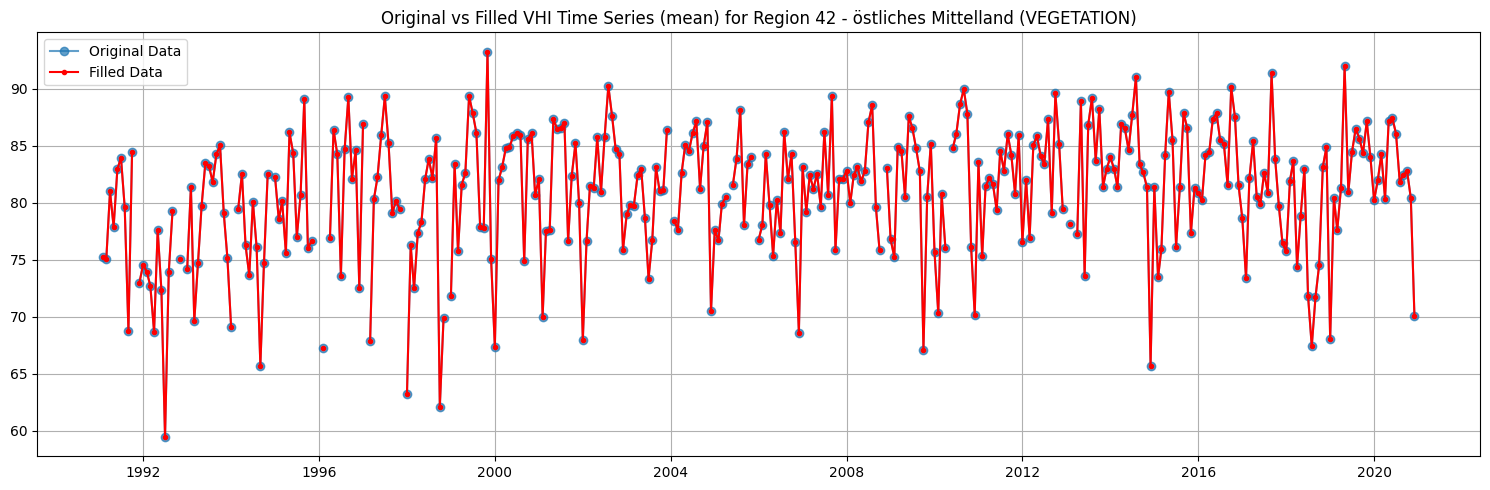


Gaps by month:
Month 1: 4 gaps
Month 2: 2 gaps
Month 3: 2 gaps
Month 5: 2 gaps
Month 10: 1 gaps
Month 11: 2 gaps
Month 12: 6 gaps


In [178]:
# Now let's visualize the results
plt.figure(figsize=(15, 5))

# Plot: Original vs Filled time series (mean)
plt.plot(df.index, df['mean'], 'o-', label='Original Data', alpha=0.7)
plt.plot(ts_filled_mean.index, ts_filled_mean, 'r.-', label='Filled Data')
plt.title(f'Original vs Filled VHI Time Series (mean) for Region {region_nr} - {region_name} ({landCover})')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Seasonal analysis of gaps
missing_by_month = df['mean'].isna().groupby(df.index.month).sum()
print("\nGaps by month:")
for month, count in missing_by_month.items():
    if count > 0:
        print(f"Month {month}: {count} gaps")

### Get monthly reference values for the climate reference period
Using the pixel count as weight for averaging

Monthly Reference Values:
                 min        p15
January     6.837024  53.545166
February   12.522016  59.078387
March      17.075977  63.172441
April      15.361204  64.179709
May        25.101708  68.961052
June       26.779179  68.048146
July       25.732000  68.761961
August     25.652515  68.835335
September  18.251773  66.274764
October    24.406337  67.805012
November   14.067793  62.754299
December    6.788086  56.575664


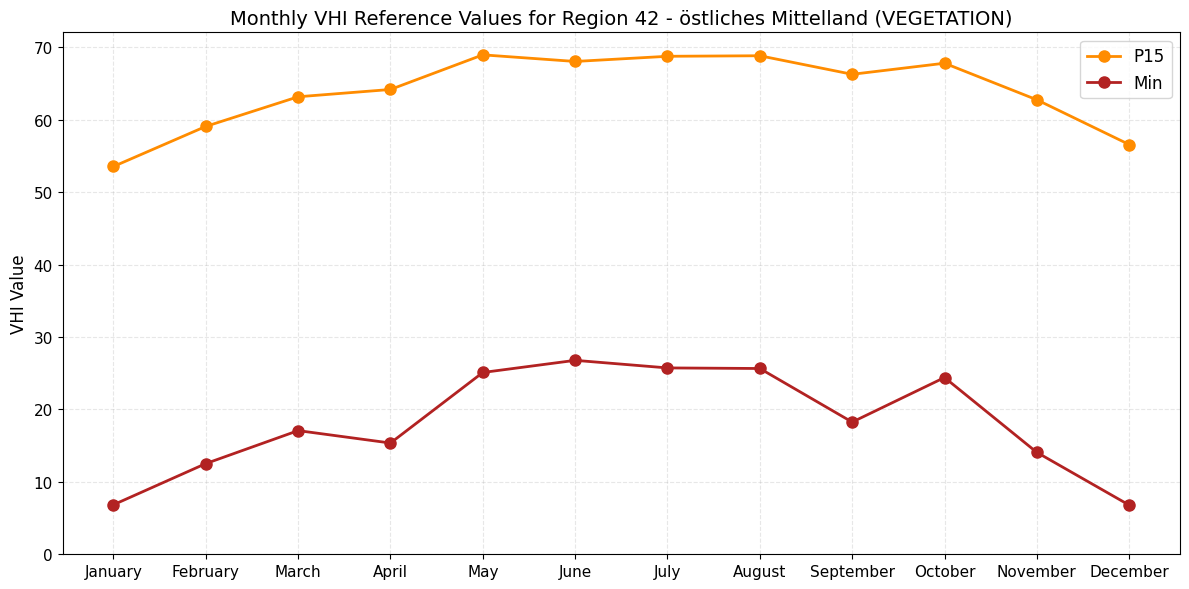

In [182]:
# Normalize pixel counts to create weights
max_pixel_count = df['pixel_count'].max()
df['weight'] = df['pixel_count'] / max_pixel_count

# Define minimum weight for months with zero pixels
min_weight = 0.05  # You can adjust this value based on your confidence in the STL-filled values

# Create weights with minimum threshold
df['weight'] = df['pixel_count'] / max_pixel_count
df['adjusted_weight'] = np.maximum(df['weight'], min_weight)

# Create a function to calculate weighted monthly reference values
def calculate_weighted_monthly_reference(time_series, weights):
    """
    Calculate weighted monthly reference values for each month
    using pixel counts as weights
    
    Parameters:
    -----------
    time_series : pandas Series
        The time series (either filled or original)
    weights : pandas Series
        Weights for each observation (normalized pixel counts)
        
    Returns:
    --------
    Series with 12 values (one for each month)
    """    
    # Group by month and calculate weighted average
    monthly_ref = pd.DataFrame({
        'value': time_series,
        'weight': weights
    })

    # Drop rows where either value or weight is NaN
    monthly_ref = monthly_ref.dropna(subset=['value', 'weight'])
    
    # Calculate weighted average per month
    result = monthly_ref.groupby(monthly_ref.index.month).apply(
        lambda x: np.average(x['value'], weights=x['weight']) if not x['weight'].isna().all() else np.mean(x['value'])
    )
    
    # Set month names as index for better readability
    month_names = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 
        5: 'May', 6: 'June', 7: 'July', 8: 'August', 
        9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }
    result.index = [month_names[m] for m in result.index]
    
    return result

# Calculate weighted reference values for p15 and min
ref_p15 = calculate_weighted_monthly_reference(ts_filled_p15, df['adjusted_weight'])
ref_min = calculate_weighted_monthly_reference(ts_filled_min, df['adjusted_weight'])

# You might also want to save these reference values
reference_values = pd.DataFrame({
    'min': ref_min,
    'p15': ref_p15
})
print("Monthly Reference Values:")
print(reference_values)

# Visualize the monthly reference values
plt.figure(figsize=(12, 6))

# Plot both lines with different colors and markers
plt.plot(reference_values.index, reference_values['p15'], 'o-', color='darkorange', linewidth=2, 
         markersize=8, label='P15')
plt.plot(reference_values.index, reference_values['min'], 'o-', color='firebrick', linewidth=2, 
         markersize=8, label='Min')

# Add labels and title
plt.title(f'Monthly VHI Reference Values for Region {region_nr} - {region_name} ({landCover})', fontsize=14)
plt.ylabel('VHI Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Customize the appearance
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.ylim(bottom=0)  # Start y-axis at 0 since VHI doesn't go below 0

# Add a light gray background grid
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()